In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
dt = pd.read_csv(io.BytesIO(uploaded['mbti_1.csv']))



Saving mbti_1.csv to mbti_1.csv


In [ ]:
data = pd.read_csv('/content/mbti_1.csv')

In [ ]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [ ]:
data['posts']

0       'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       'I'm finding the lack of me in these posts ver...
2       'Good one  _____   https://www.youtube.com/wat...
3       'Dear INTP,   I enjoyed our conversation the o...
4       'You're fired.|||That's another silly misconce...
                              ...                        
8670    'https://www.youtube.com/watch?v=t8edHB_h908||...
8671    'So...if this thread already exists someplace ...
8672    'So many questions when i do these things.  I ...
8673    'I am very conflicted right now when it comes ...
8674    'It has been too long since I have been on per...
Name: posts, Length: 8675, dtype: object

In [ ]:
# Remove any rows with missing values.
data = data.dropna(axis=0)

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

There are many links and symbols in the text data which are needed to be 
removed.
Function to clean the text data :

In [ ]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
       # removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
       #  removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [ ]:
train_data.posts,train_length=clear_text(train_data)
test_data.posts,test_length=clear_text(test_data)


100%|██████████| 1735/1735 [00:00<00:00, 1958.98it/s]


In [ ]:
px.pie(train_data,names='type',title='Personality type',hole=0.3)

In [ ]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]



In [ ]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)



TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x7ff687b64710>)

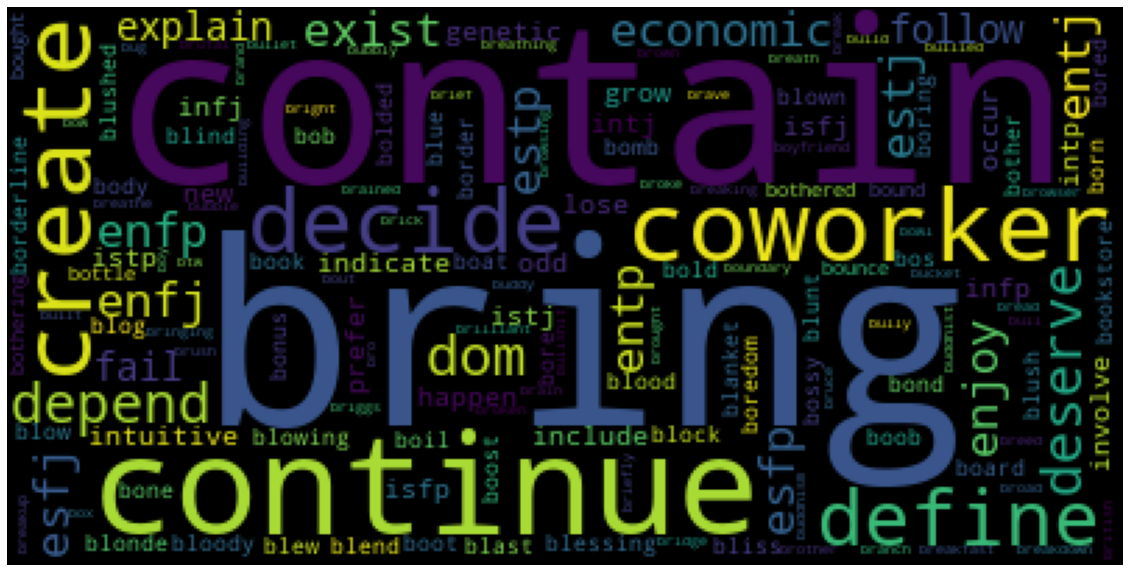

In [ ]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [ ]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

# ***Logistic Regression***

Hyper Paramter Optimization

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1)
X1,X2=train_test_split(train_post,test_size=0.1,random_state=42)
Y1,Y2=train_test_split(train_target,test_size=0.1,random_state=42)
#result = search.fit(train_post,train_target)
result = search.fit(X2,Y2)
result.best_score_
result.best_params_


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
models_accuracy={}
model_log=LogisticRegression(penalty='l2',solver='lbfgs',max_iter=3000,C=10,n_jobs=-1)
#model_log=LogisticRegression(penalty='l1',solver='liblinear',max_iter=3000,C=10,n_jobs=-1)
model_log.fit(train_post,train_target)
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.96      0.97       152
        ENFP       0.98      0.98      0.98       540
        ENTJ       1.00      0.97      0.98       185
        ENTP       0.97      0.98      0.98       548
        ESFJ       1.00      0.94      0.97        33
        ESFP       1.00      0.92      0.96        38
        ESTJ       1.00      0.94      0.97        31
        ESTP       0.99      0.99      0.99        71
        INFJ       0.98      0.98      0.98      1176
        INFP       0.98      0.99      0.99      1466
        INTJ       0.98      0.99      0.98       873
        INTP       0.98      0.99      0.99      1043
        ISFJ       0.98      0.98      0.98       133
        ISFP       0.99      0.98      0.98       217
        ISTJ       0.98      0.99      0.98       164
        ISTP       0.99      0.99      0.99       270

    accuracy                           0.98      

In [ ]:
accuracy_score(test_target,model_log.predict(test_post))

0.6455331412103746

In [ ]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

# ***Linear Support Vector classifier***

In [ ]:
model_linear_svc=LinearSVC(C=1)
model_linear_svc.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.98      0.97      0.97       152
        ENFP       0.97      0.97      0.97       540
        ENTJ       1.00      0.98      0.99       185
        ENTP       0.97      0.98      0.97       548
        ESFJ       1.00      0.97      0.98        33
        ESFP       1.00      0.89      0.94        38
        ESTJ       1.00      0.94      0.97        31
        ESTP       0.99      0.99      0.99        71
        INFJ       0.98      0.97      0.97      1176
        INFP       0.97      0.98      0.98      1466
        INTJ       0.98      0.98      0.98       873
        INTP       0.98      0.98      0.98      1043
        ISFJ       0.98      0.97      0.98       133
        ISFP       0.99      0.98      0.99       217
        ISTJ       0.98      0.99      0.98       164
        ISTP       0.99      0.99      0.99       270

    accuracy                           0.98      

In [ ]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

# ***Support Vector classifier***

In [ ]:
#model_svc=SVC()
#model_svc.fit(train_post,train_target)

#print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
#print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

# ***Multinomial Naive Bayes***

In [ ]:
model_multinomial_nb=MultinomialNB(alpha=0.1, fit_prior=False, class_prior=None)
model_multinomial_nb.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.76      0.96      0.85       152
        ENFP       0.68      0.85      0.76       540
        ENTJ       0.68      0.92      0.78       185
        ENTP       0.79      0.84      0.82       548
        ESFJ       0.97      0.88      0.92        33
        ESFP       0.58      0.92      0.71        38
        ESTJ       0.82      0.87      0.84        31
        ESTP       0.92      0.99      0.95        71
        INFJ       0.82      0.71      0.76      1176
        INFP       0.82      0.75      0.78      1466
        INTJ       0.83      0.76      0.79       873
        INTP       0.84      0.79      0.81      1043
        ISFJ       0.84      0.97      0.90       133
        ISFP       0.76      0.92      0.83       217
        ISTJ       0.86      0.91      0.88       164
        ISTP       0.78      0.88      0.83       270

    accuracy                           0.80      

In [ ]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

In [ ]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,logistic regression,0.645533
1,Linear Support Vector classifier,0.639769
2,Multinomial Naive Bayes,0.512392
